# Notebook

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, Rescaling
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
#import os
#import seaborn as sns
#sns.set_style('darkgrid')
#from PIL import Image
#from sklearn.metrics import confusion_matrix, classification_report
#from IPython.core.display import display, HTML
import yaml

Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import yaml

Reading files

In [2]:
try:
    with open('params.yml','r') as file:
        config = yaml.safe_load(file)  
except Exception as e:
    print('Error reading the config file')

In [3]:
config

{'raw_data': 'GroundTruth.csv'}

In [4]:
df=pd.read_csv(config['raw_data'])
print(df.shape)
df.head()


(10015, 8)


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df['image']=df['image'].apply(lambda x: x+ '.jpg')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0


String to put images in folders (using GitBash)

In [6]:
s = ''
for n in range(0,len(df)):
    if df['VASC'][n] == 1:
        s += df['image'][n] + ' '

In [7]:
#s

## Loading images

In [8]:
import pathlib

In [9]:
data_dir = pathlib.Path('C:/Users/joana/projects/skin/images_folder')

In [10]:
data_dir

WindowsPath('C:/Users/joana/projects/skin/images_folder')

In [11]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

10015


In [12]:
df['image'][0]

'ISIC_0024306.jpg'

(450, 600, 3)


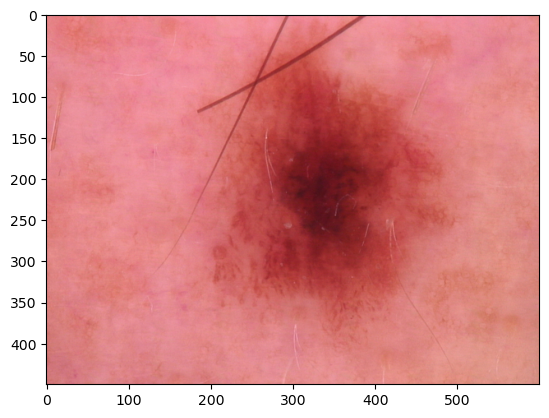

In [13]:
img=plt.imread('images_folder/NV/'+df['image'][0])
print (img.shape)
plt.imshow(img)

## Create dataset

In [14]:
batch_size = 32
img_height = 224
img_width = 224

### Splitting between train, validation and testing

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
        rescale=1/255,
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2],# brightness
        validation_split=0.3)

In [16]:
train_ds = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory=data_dir,
                                                 shuffle=True,
                                                 target_size=(img_height, img_width),
                                                 subset="training",
                                                 class_mode='sparse')

val_ds = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory=data_dir,
                                                 shuffle=True,
                                                 target_size=(img_height, img_width),
                                                 subset="validation",
                                                 class_mode='sparse')

Found 7014 images belonging to 7 classes.
Found 3001 images belonging to 7 classes.


train_ds = image_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = image_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Separating validation set into validation and test sets

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.skip((2*val_batches) // 3)
val_ds = val_ds.take((2*val_batches) // 3)

print('Batches for testing -->', test_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())

class_names = train_ds.class_names
print(class_names)

### Examples of each class

In [17]:
train_ds

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: 'DirectoryIterator' object has no attribute 'take'

<Figure size 1000x1000 with 0 Axes>

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Normalizing

In [ ]:
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

Color values are in the [0, 255] range. Values will be rescaled to [0, 1] range.

## Model

In [19]:
num_classes = 7#len(class_names)
#layers.Conv2D(16, 3, input_shape=(img_height, img_width,3), activation='relu'),

Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))

In [21]:
model = Sequential([
  #layer 1
  layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(img_height, img_width,3)),
  layers.MaxPooling2D(pool_size=(2,2)),
  #layer 2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #layer 3
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #layer 4
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),  
  
  #end
  layers.Flatten(),
  layers.Dropout(rate=0.3),
  layers.Dense(256, activation='relu'),
  layers.Dropout(rate=0.2),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 64)       0

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
epochs = 100

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
220/220 [==============================] - 610s 3s/step - loss: 0.8297 - accuracy: 0.6906 - val_loss: 0.7854 - val_accuracy: 0.7038
Epoch 2/100
220/220 [==============================] - 614s 3s/step - loss: 0.8117 - accuracy: 0.7009 - val_loss: 0.7748 - val_accuracy: 0.7158
Epoch 3/100
220/220 [==============================] - 616s 3s/step - loss: 0.8022 - accuracy: 0.7019 - val_loss: 0.7722 - val_accuracy: 0.7204
Epoch 4/100
220/220 [==============================] - 614s 3s/step - loss: 0.7960 - accuracy: 0.7087 - val_loss: 0.7580 - val_accuracy: 0.7134
Epoch 5/100
220/220 [==============================] - 617s 3s/step - loss: 0.7877 - accuracy: 0.7062 - val_loss: 0.7451 - val_accuracy: 0.7214
Epoch 6/100
220/220 [==============================] - 617s 3s/step - loss: 0.7748 - accuracy: 0.7109 - val_loss: 0.7660 - val_accuracy: 0.7088
Epoch 7/100
220/220 [==============================] - 624s 3s/step - loss: 0.7747 - accuracy: 0.7137 - val_loss: 0.7303 - val_accuracy:

## Transfer Learning

In [ ]:
from keras.models import load_model
base_model = load_model("model224.h5")

In [ ]:
base_model.layers

In [ ]:
for i in range(4):
    base_model.layers[i].trainable = False
for i in range(4,12):
    base_model.layers[i].trainable = True

In [ ]:
num_classes

In [ ]:
ll = base_model.layers[8].output
ll = layers.Dense(32)(ll)
ll = layers.Dense(64)(ll)
ll = layers.Dense(num_classes,activation="softmax")(ll)

new_model = model(inputs=base_model.input,outputs=ll)

In [ ]:
inputs = keras.Input(shape=(img_height, img_width, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
#  layers.Dropout(rate=0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, name = 'softmax')
])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)

In [24]:
#%%writefile -a functions.py

def plot_acc_loss(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.show()

%run functions.py

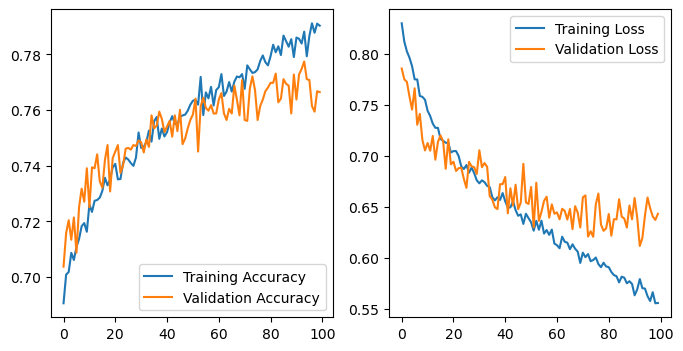

In [27]:
plot_acc_loss(history,epochs)

In [ ]:
#with open('../model.pkl', 'wb') as file: pickle.dump(model, file)

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

## Testing

In [49]:
score = model.evaluate_generator(val_ds)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

C:\Users\joana\AppData\Local\Temp\ipykernel_11612\3655792196.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(val_ds)


Test loss: 0.6411512494087219
Test accuracy: 0.7710763216018677


In [ ]:
predict=model.predict_generator(valid_ds)
# predict the class label
y_classes = predict.argmax(axis=-1)

### alternative

In [34]:
predictions = model.predict(val_ds)
score = tf.nn.softmax(predictions)

94/94 [==============================] - 111s 1s/step


In [35]:
score

<tf.Tensor: shape=(3001, 7), dtype=float32, numpy=
array([[0.11761204, 0.11750124, 0.1301898 , ..., 0.11770809, 0.28063333,
        0.11728778],
       [0.11492486, 0.11498421, 0.11579445, ..., 0.11497963, 0.3093605 ,
        0.11491972],
       [0.14268993, 0.18384326, 0.1386153 , ..., 0.13565114, 0.13589266,
        0.12307874],
       ...,
       [0.12359002, 0.2542693 , 0.11952592, ..., 0.12342858, 0.11918052,
        0.14046356],
       [0.16707368, 0.16202693, 0.15006176, ..., 0.1308659 , 0.14190203,
        0.12339677],
       [0.1147284 , 0.11472841, 0.1147284 , ..., 0.11472842, 0.11486503,
        0.311493  ]], dtype=float32)>

In [36]:
y_test_pred = np.argmax(score, axis=-1)

In [37]:
y_test_pred

array([5, 5, 1, ..., 1, 0, 6], dtype=int64)

In [45]:
val_ds

In [ ]:
y_test =  np.array([])
for x, y in val_ds:
    print(y)
 #   y_test = np.concatenate([y_test, y.numpy()])

In [46]:
class_names

NameError: name 'class_names' is not defined

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(conf_mat, display_labels=class_names).plot()

ValueError: Found input variables with inconsistent numbers of samples: [0, 3001]

In [ ]:
# In Tensorflow
model.save('model224_3.h5') # Saves the entire model to a single artifact

In [ ]:
path = ('images_folder/AKIEC/'+df['image'][23])

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
predictions = model.predict(val_ds)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)